In [1]:
%matplotlib inline

import seaborn as sns

import numpy as np
import scipy as sp
import nibabel as nib
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.metrics import silhouette_samples, silhouette_score


sns.set(font_scale=1.4)
sns.set_style("whitegrid", {'axes.grid' : False})

/Users/hanam/venv/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/Users/hanam/venv/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/hanam/venv/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/hanam/venv/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/Users/hanam/venv/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary inco

/Users/hanam/venv/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/Users/hanam/venv/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .pairwise_fast import _chi2_kernel_fast, _sparse_manhattan
/Users/hanam/venv/lib/python2.7/site-packages/sklearn/neighbors/__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .ball_tree import BallTree
/Users/hanam/venv/lib/python2.7/site-packages/sklearn/neighbors/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .kd_tree import KDTree
/Users/hanam/venv/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeW

In [2]:
nibfile = nib.load("/Users/hanam/Documents/tract_clustering_3/C1/Volume4D.nii.gz")
data = nibfile.get_data()

In [3]:
feature_names = [
    "g_ratio",
    "axon_equiv_diameter",
    "myelin_equiv_diameter",
    "myelin_thickness",
    "myelin_area",
    "axon_area",
    "number_axons",
    "axon_equiv_diameter_std",
    "axon_equiv_diameter_axon_volume_corrected",
    "mvf",
    "avf",
    "fr",
    "solidity",
    "eccentricity",
    "orientation",
    "orientation_dispersion",
    "circularity"
]

In [4]:
data = data.transpose((1, 0, 2, 3))

# Ignore solidity, eccent., orient., etc.
data = data[..., 0:12]
data = data.squeeze(axis=2)

In [5]:
data.shape

(151, 151, 6)

In [6]:
original_shape = data.shape[0:2]

In [7]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

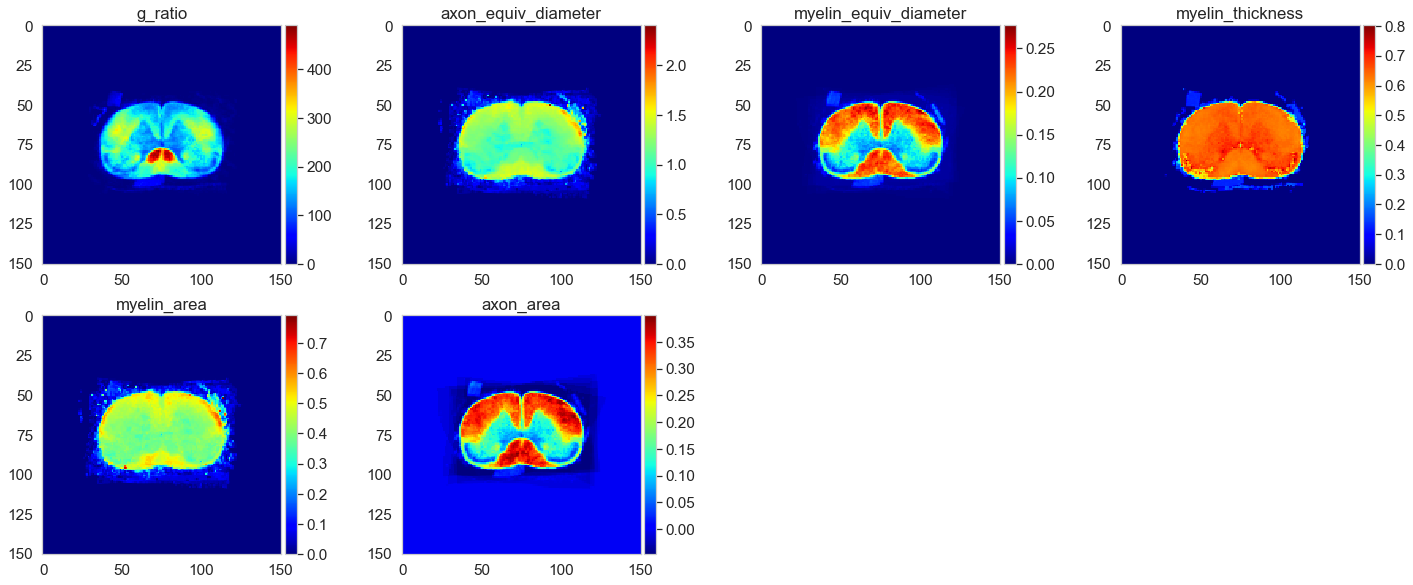

In [8]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, data.shape[2]+1):
    ax = fig.add_subplot(5, 4, i)
    img = ax.imshow(data[..., i-1], cmap="jet")
    # Center line
    #ax.axvline(original_shape[1] // 2) 
    plt.title(feature_names[i-1])
    colorbar(img)

plt.tight_layout(h_pad=1)

### Connectivity

In [9]:
voxvox = data.shape[0] * data.shape[1]

In [10]:
symmetry = np.zeros((voxvox, voxvox), dtype=np.int64)
rlen, clen = data.shape[0:2]

for ridx in range(rlen):
    for cidx in range(0, clen // 2):
        p1_idx = (ridx * clen) + cidx
        p2_idx = (ridx * clen) + (cidx + (clen // 2))
        symmetry[p1_idx][p2_idx] = 1
        symmetry[p2_idx][p1_idx] = 1

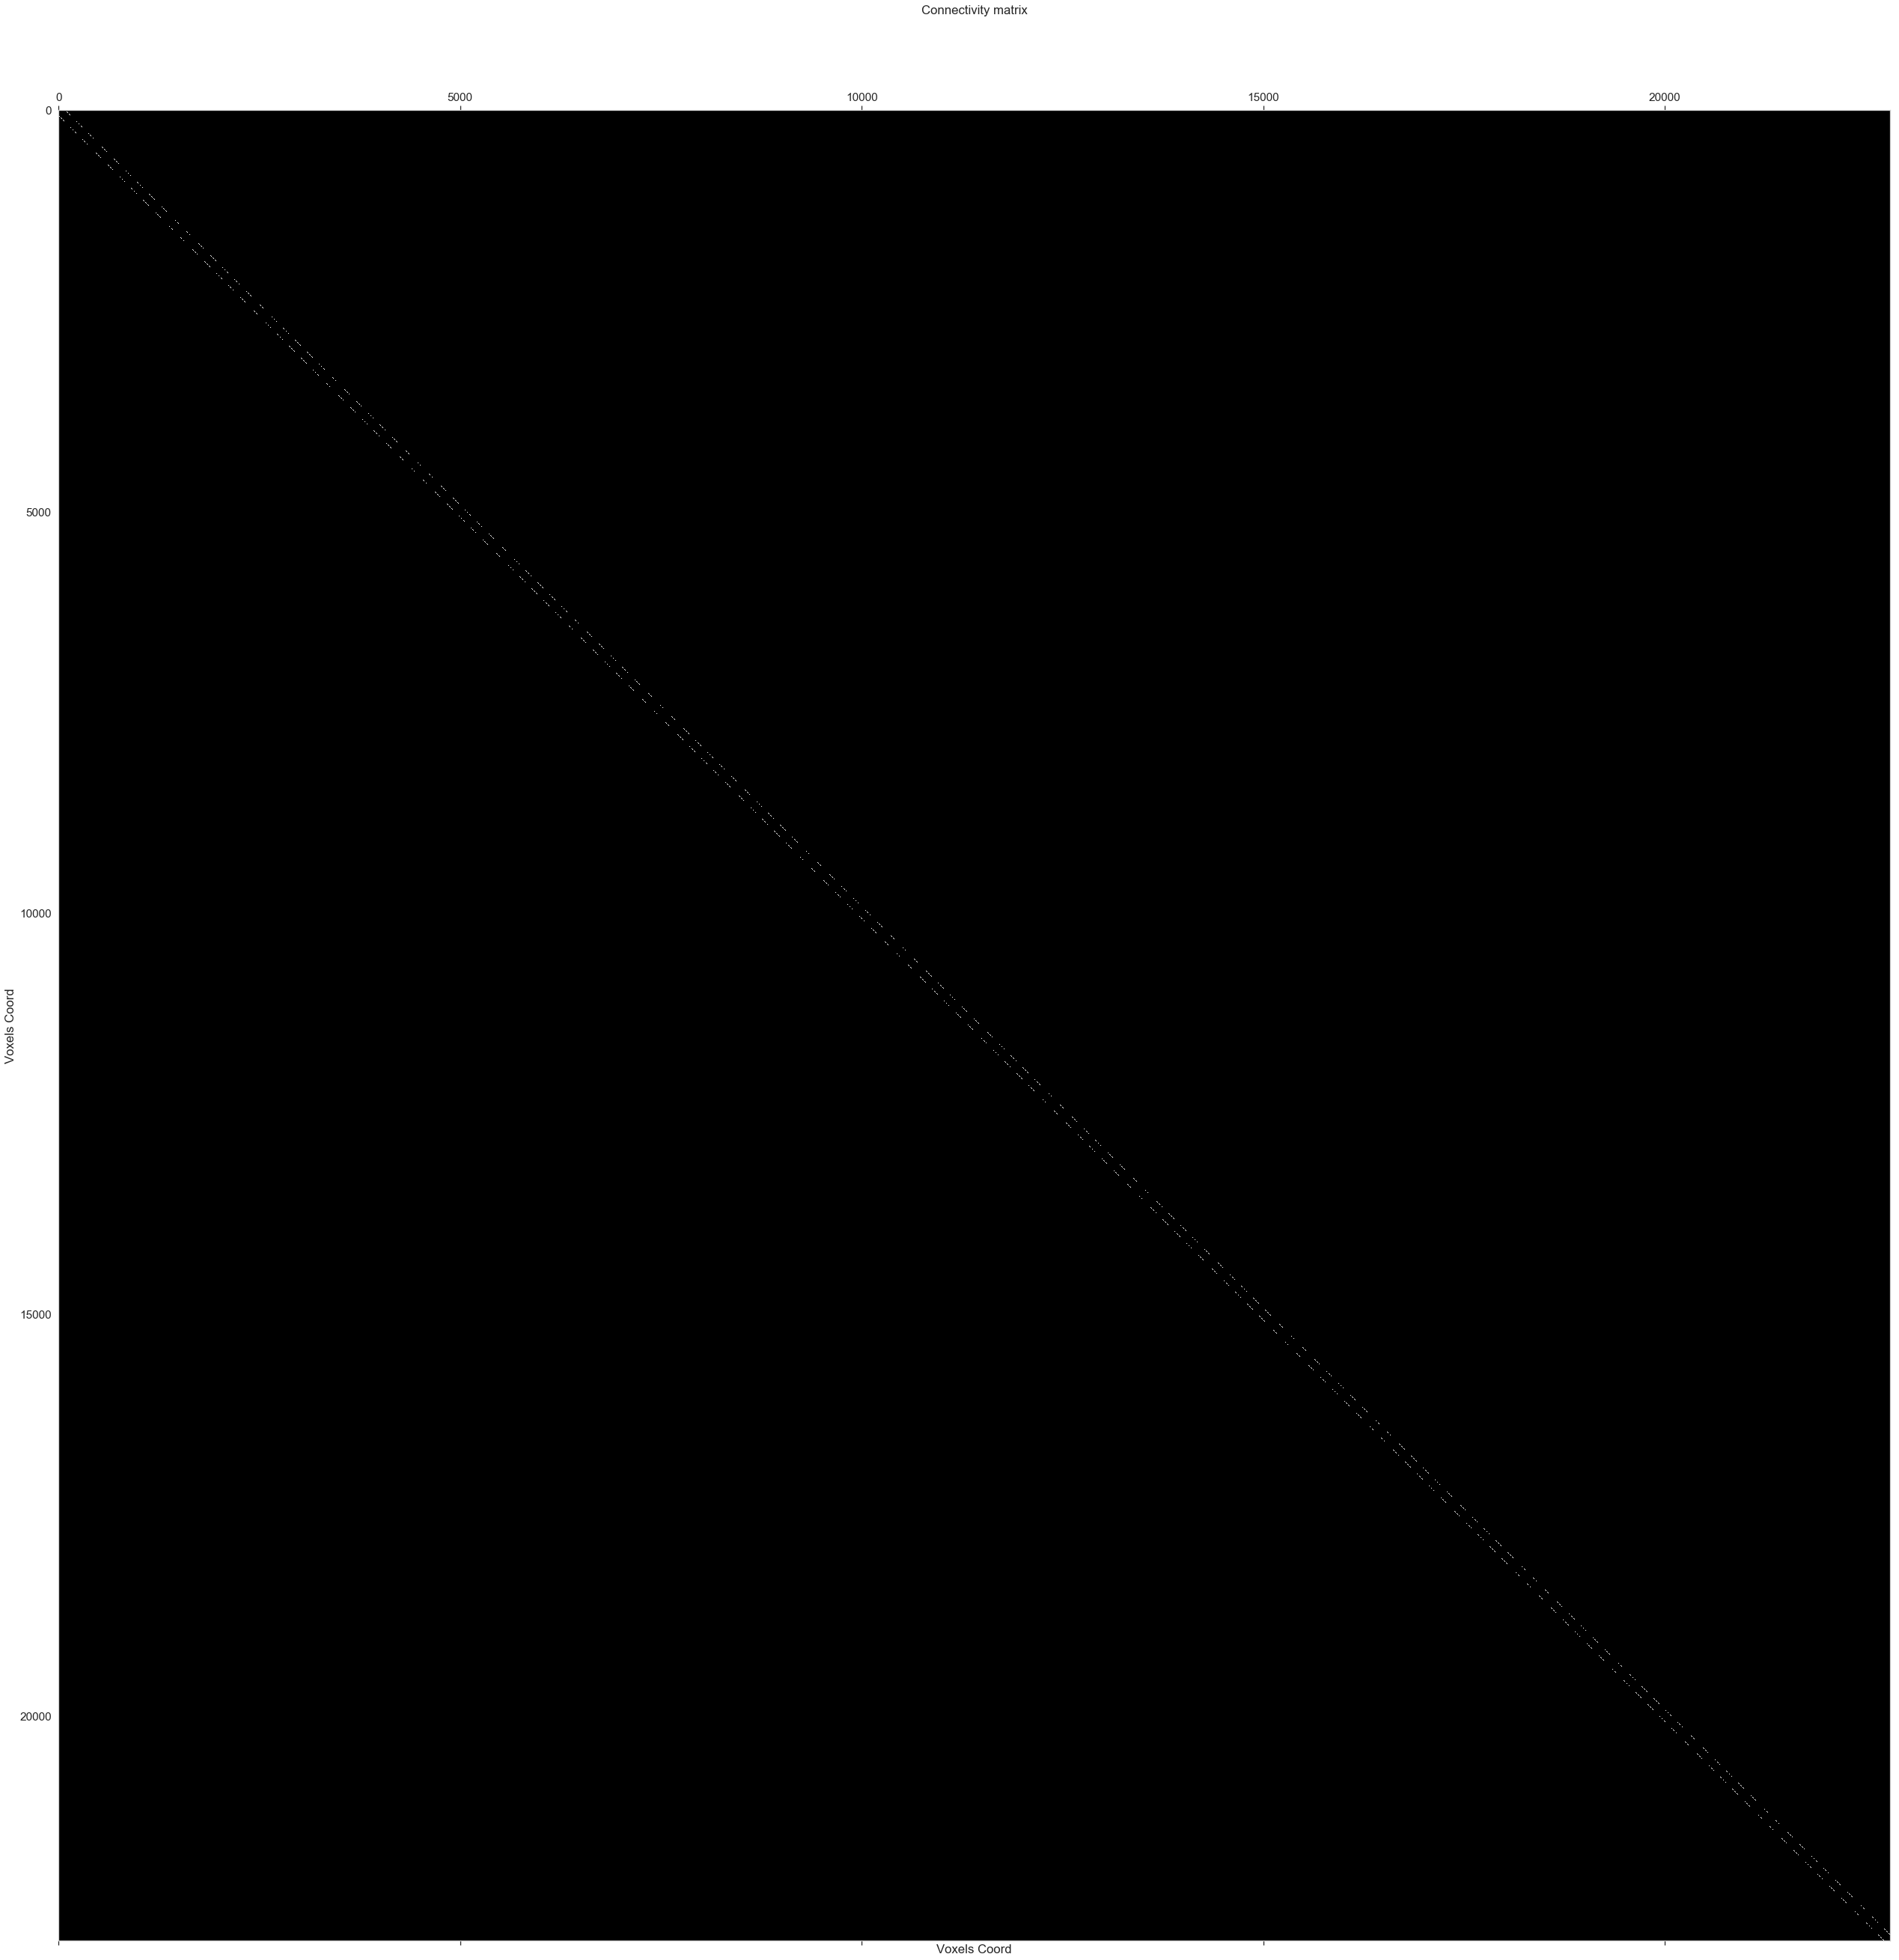

In [12]:
fig, ax = plt.subplots(figsize=(50, 45)) 
ax.matshow(symmetry, cmap="gray", interpolation="none")
ax.set_title("Connectivity matrix")
ax.set_xlabel("Voxels Coord")
ax.set_ylabel("Voxels Coord");

In [60]:
connectivity = grid_to_graph(n_x=data.shape[0],
                             n_y=data.shape[1],
                             return_as=np.ndarray)

In [61]:
data = data.reshape(-1, data.shape[2])

In [62]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [63]:
data.shape

(22801, 6)

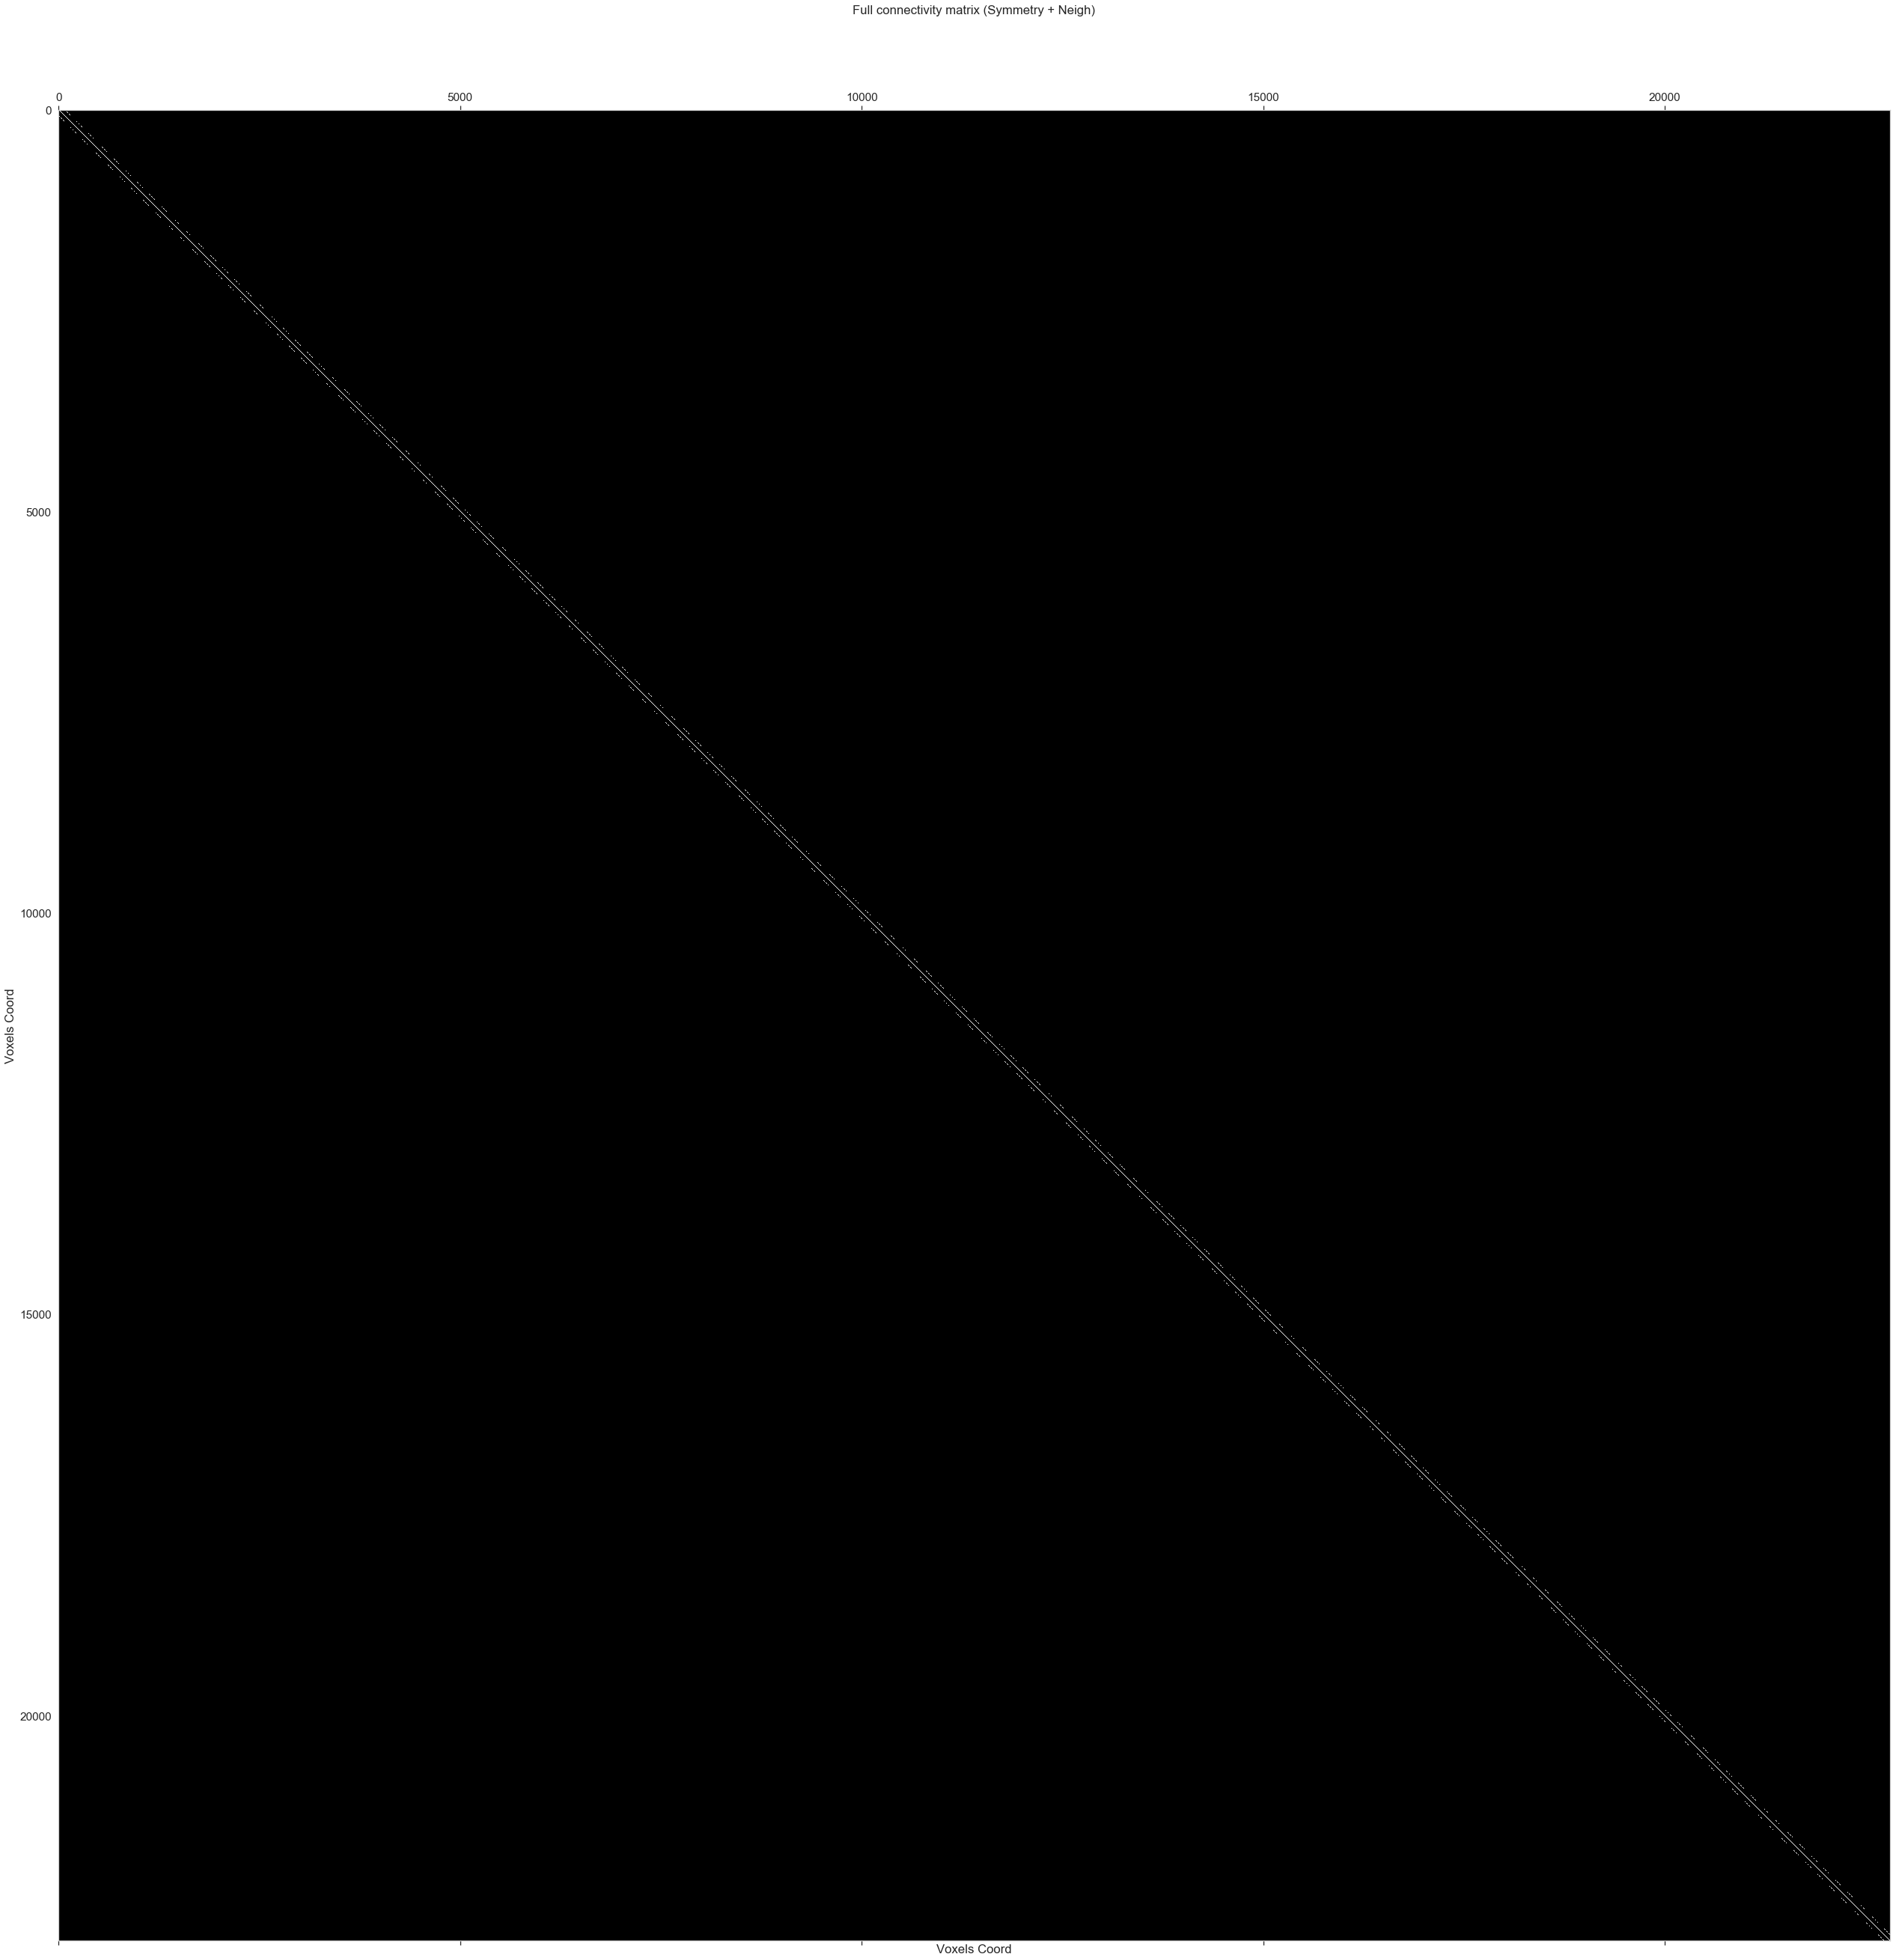

In [64]:
fig, ax = plt.subplots(figsize=(50, 45)) 
ax.matshow(connectivity+symmetry, cmap="gray", interpolation="none")
ax.set_title("Full connectivity matrix (Symmetry + Neigh)")
ax.set_xlabel("Voxels Coord")
ax.set_ylabel("Voxels Coord");

# t-SNE

In [65]:
data_embedded = TSNE(n_components=2, verbose=3, perplexity=40).fit_transform(data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 22801 samples in 0.640s...
[t-SNE] Computed neighbors for 22801 samples in 3.545s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22801
[t-SNE] Computed conditional probabilities for sample 2000 / 22801
[t-SNE] Computed conditional probabilities for sample 3000 / 22801
[t-SNE] Computed conditional probabilities for sample 4000 / 22801
[t-SNE] Computed conditional probabilities for sample 5000 / 22801
[t-SNE] Computed conditional probabilities for sample 6000 / 22801
[t-SNE] Computed conditional probabilities for sample 7000 / 22801
[t-SNE] Computed conditional probabilities for sample 8000 / 22801
[t-SNE] Computed conditional probabilities for sample 9000 / 22801
[t-SNE] Computed conditional probabilities for sample 10000 / 22801
[t-SNE] Computed conditional probabilities for sample 11000 / 22801
[t-SNE] Computed conditional probabilities for sample 12000 / 22801
[t-SNE] Computed conditional probabilities for sa

In [66]:
num_clusters = 15
clustering = AgglomerativeClustering(linkage="ward", n_clusters=num_clusters,
                                     connectivity=connectivity)
clustering.fit(data)
labels = clustering.labels_

In [67]:
labels = labels.reshape(*original_shape)

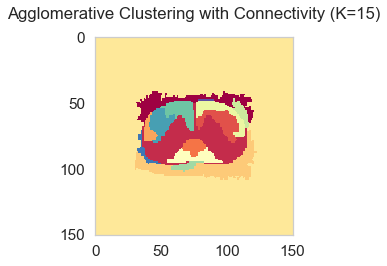

In [68]:
plt.imshow(labels, cmap="Spectral")
plt.title("Agglomerative Clustering with Connectivity (K={})".format(num_clusters), pad=18)
plt.tight_layout()

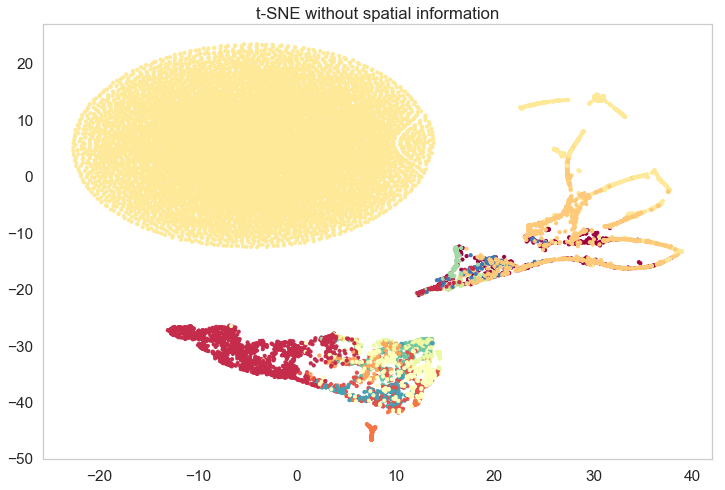

In [69]:
plt.figure(figsize=(12, 8))
plt.scatter(data_embedded[:, 0], data_embedded[:, 1],
            cmap="Spectral", s=10, c=clustering.labels_)
plt.title("t-SNE without spatial information")
plt.show()

### Clustering with adjacency connectivity matrix

0.83867127
0.76527995
0.75745803
0.7571769
0.757537
0.75682646
0.7537992
0.75330234
0.7505702
0.7465115
0.73901963
0.7372374
0.73926735
0.735982
0.732757
0.71529096
0.7107541
0.71321905
0.71451104
0.7130132
0.71276027
0.71091753
0.7109873
0.7124268
0.71194303


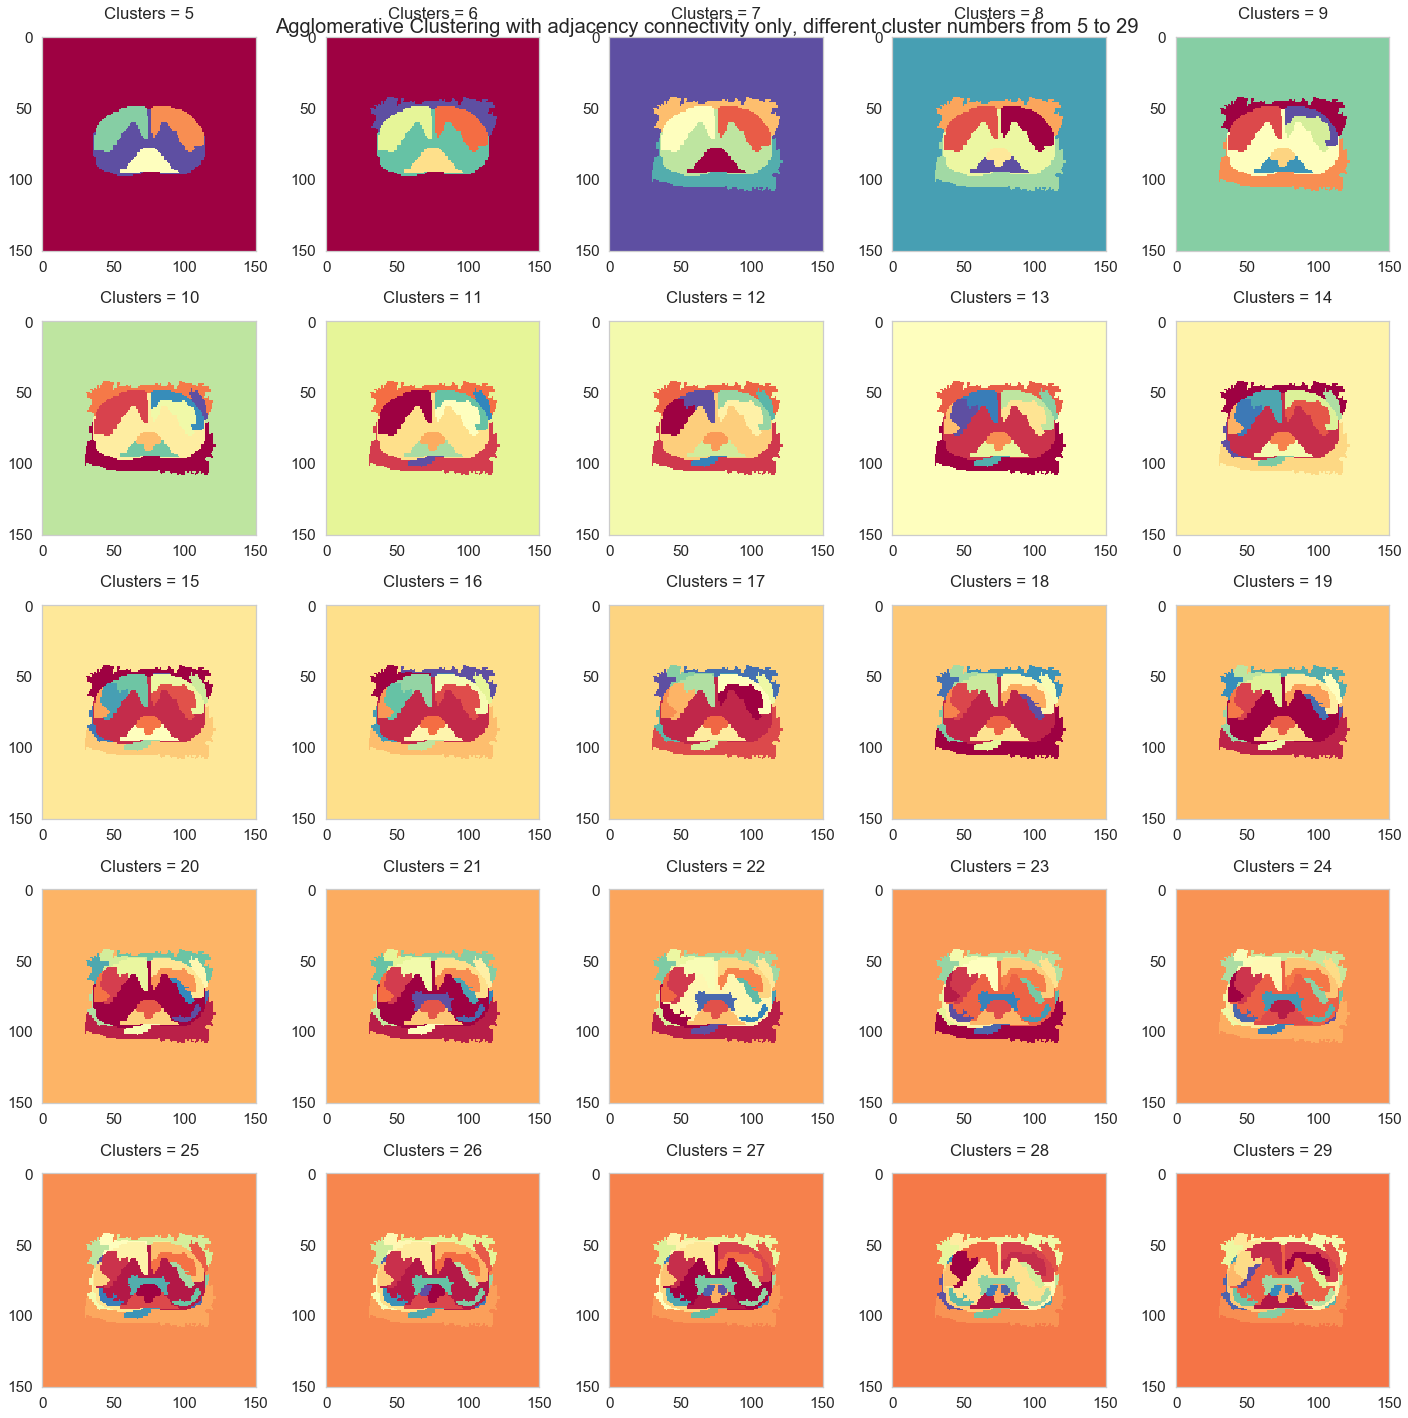

In [70]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 26):
    clustering = AgglomerativeClustering(linkage="ward", n_clusters=i+4,
                                         connectivity=connectivity)
    clustering.fit(data)
    labels = clustering.labels_
    silhouette= silhouette_score(data, labels)
    print silhouette
    
    labels = labels.reshape(*original_shape)

    ax = fig.add_subplot(5, 5, i)
    img = ax.imshow(labels, cmap="Spectral")
    plt.title("Clusters = {}".format(i+4), pad=18)
    plt.tight_layout()

plt.suptitle("Agglomerative Clustering with adjacency connectivity only, different cluster numbers from 5 to 29")
plt.tight_layout(h_pad=1)

In [72]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [73]:
h1= 35
h2= 115
w1= 35
w2= 120

### Clustering with symmetry connectivity + adjacency matrix

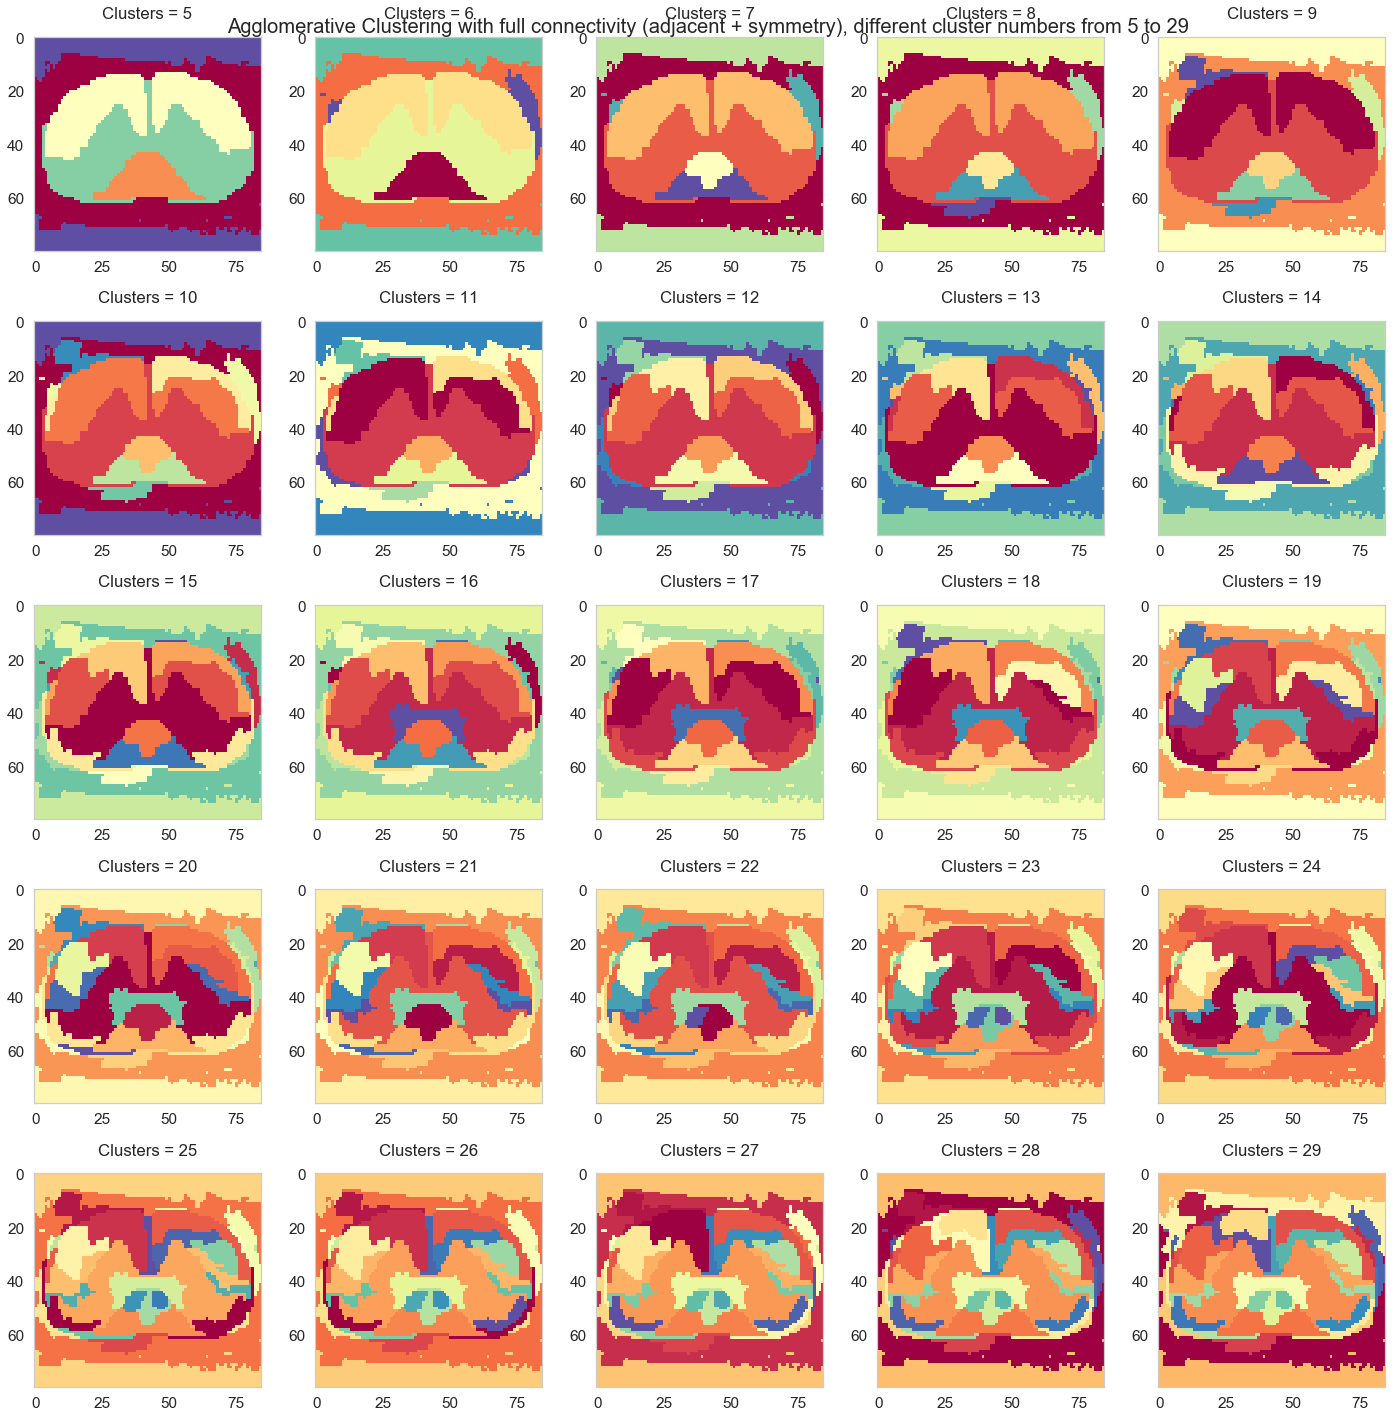

In [74]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 26):
    clustering = AgglomerativeClustering(linkage="ward", n_clusters=i+4,
                                         connectivity=connectivity+symmetry)
    clustering.fit(data)
    labels = clustering.labels_
    labels = labels.reshape(*original_shape)
    
    im_crop= crop_center(labels, w2-w1, h2-h1)

    ax = fig.add_subplot(5, 5, i)
    img = ax.imshow(im_crop, cmap="Spectral")
    plt.title("Clusters = {}".format(i+4), pad=18)
    plt.tight_layout()

plt.suptitle("Agglomerative Clustering with full connectivity (adjacent + symmetry), different cluster numbers from 5 to 29")
plt.tight_layout(h_pad=1)